In [1]:
import pandas_datareader.data as web
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv', index_col=0)
df.head()

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,2016-04-05,63,7236.0,1700,90,0.0,0.0


In [4]:
#drop unnecessary columns
df = df.drop(columns=['n_sick', 'calls', 'n_duty', 'n_sby', 'dafted'])
df.head()

,date,sby_need
0,2016-04-01,4.0
1,2016-04-02,70.0
2,2016-04-03,0.0
3,2016-04-04,0.0
4,2016-04-05,0.0


In [5]:
# to use models provided by stats library we need to set date column as index
df.index = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.drop(columns=['date'])

In [6]:
df.head()

,sby_need
date,
2016-04-01,4.0
2016-04-02,70.0
2016-04-03,0.0
2016-04-04,0.0
2016-04-05,0.0


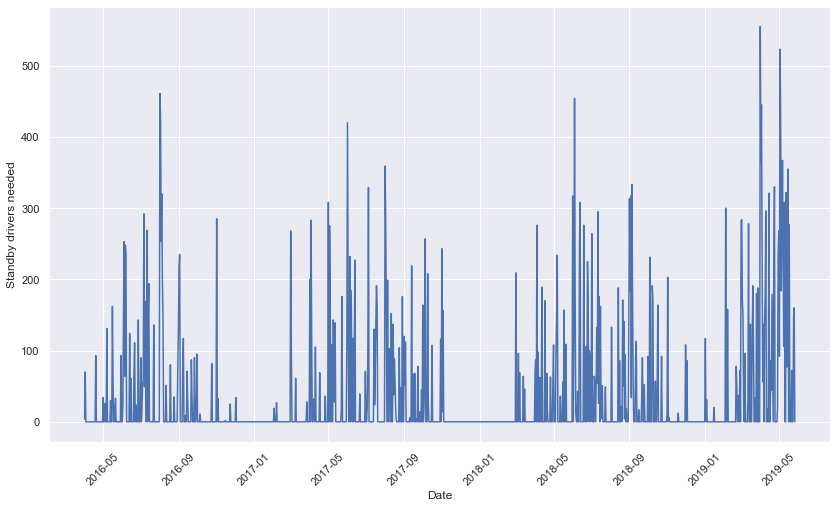

In [7]:
# visualize
sns.set()
plt.figure(figsize=(14,8))

plt.ylabel('Standby drivers needed')
plt.xlabel('Date')
plt.xticks(rotation=45)

plt.plot(df.index, df['sby_need'], )


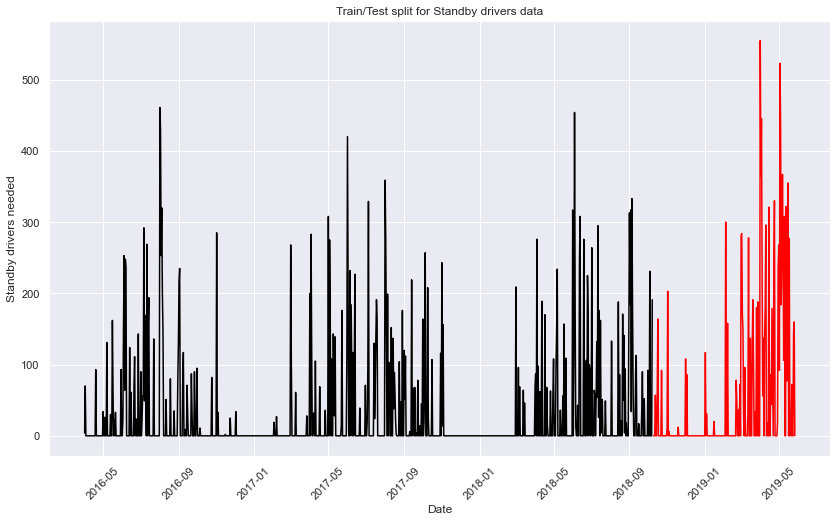

In [8]:
# split data so that everything before 2018-10-09 will serve as training data
# everything after will serve as test data

train = df[df.index < pd.to_datetime("2018-10-09", format='%Y-%m-%d')]
test = df[df.index > pd.to_datetime("2018-10-09", format='%Y-%m-%d')]

plt.figure(figsize=(14,8))
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Standby drivers needed')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Standby drivers data")
plt.show()

## ARMA model

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [10]:
# define input
y = train['sby_need']

In [11]:
# define model
ARMAmodel = SARIMAX(y, order = (1, 0, 1))

/Users/kata/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/kata/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [12]:
# fit model
ARMAmodel = ARMAmodel.fit()

In [13]:
# generate predictions

y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

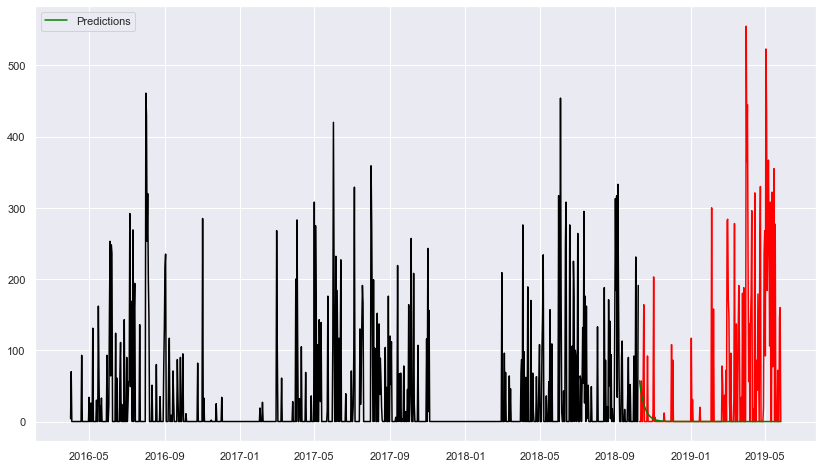

In [14]:
# plot results
plt.figure(figsize=(14,8))
plt.plot(train, color = "black") #?
plt.plot(test, color = "red") #?
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [16]:
# evalute with RMSE
arma_rmse = np.sqrt(mean_squared_error(test["sby_need"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  118.69800238961076


## ARIMA model

In [17]:
from statsmodels.tsa.arima.model import ARIMA

In [18]:
import warnings

warnings.filterwarnings("ignore")

In [19]:
ARIMAmodel = ARIMA(y, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

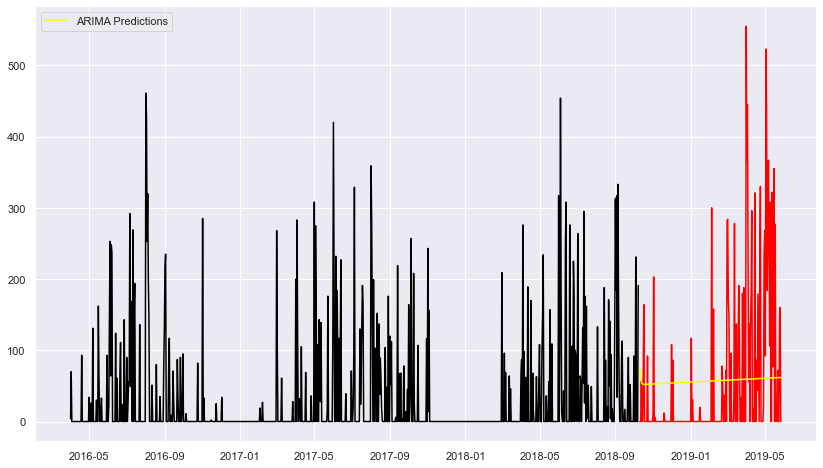

In [20]:
plt.figure(figsize=(14,8))
plt.plot(train, color = "black") #?
plt.plot(test, color = "red") #?
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

In [21]:
from sklearn.metrics import mean_squared_error


In [22]:
arma_rmse = np.sqrt(mean_squared_error(test["sby_need"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  105.22425301323776


## SARIMA

In [23]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

In [24]:
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

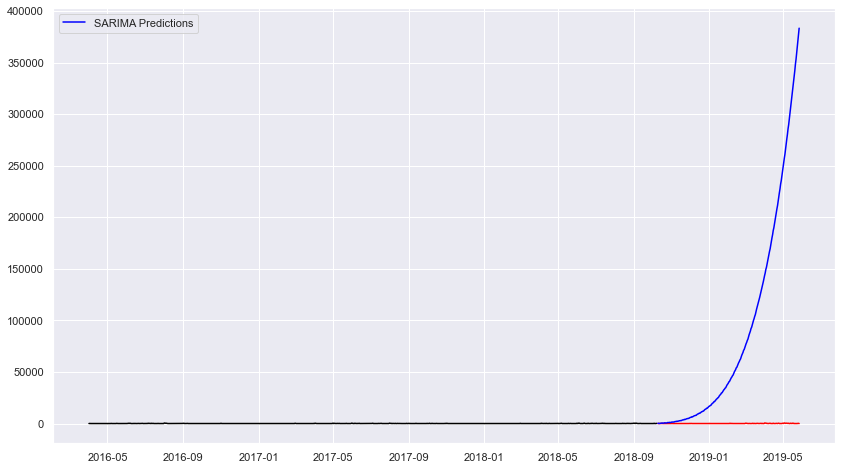

In [25]:
plt.figure(figsize=(14,8))
plt.plot(train, color = "black") #?
plt.plot(test, color = "red") #?
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.legend()

In [26]:
sarima_rmse = np.sqrt(mean_squared_error(test["sby_need"].values, y_pred_df["Predictions"]))
print("RMSE: ",sarima_rmse)

RMSE:  135994.13237102475


## Simple Exponential Smoothing (SES)

In [27]:
import itertools